# Display results
This code enables easy selection of experimental results and plotting their values

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def satistifies_conditions(experiment, conditions):
    """ Check if experiment hyperparameters satisfy desired conditions
    """
    hp = experiment['hyperparameters']
    
    # Check if each condition satistified
    # If not, then return false
    for key, value in conditions.items():
        if key not in hp or hp[key] not in value:
            return False
    
    # All conditions are satisfied
    return True

In [3]:
def load_experiments_satisfying_conditions(conditions, anti_conditions=dict()):
    """ Load all experiments that satisfy the given conditions,
    except those that also satisfy the anticonditions
    Return them as a list.
    """
    # Get all experiment filenames
    experiment_filenames = [f for f in os.listdir(os.getcwd()) if f[-5:] == '.json']
    
    # Initialize list of experiments that satisfy the conditions
    experiments_satisfactory = []
    
    # Load each experiment file
    for experiment_filename in experiment_filenames:
        with open(experiment_filename) as experiment_file:
            experiment = json.load(experiment_file)
            
            # Check if experiment satistifies conditions
            # If so, append to list of experiments satisfying the conditions
            if satistifies_conditions(experiment, conditions):
                if anti_conditions == dict() or not satistifies_conditions(experiment, anti_conditions):
                    experiments_satisfactory.append(experiment)
                
    return experiments_satisfactory

In [4]:
def get_per_epoch_performance(experiments, dataset, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_accuracy', 'average_loss'}
    assert dataset in {'train', 'test'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_epochs = experiments[0]['hyperparameters']['epochs']
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_epochs))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][dataset][measure]
        
    return performance
        

# Example usage

In [5]:
# Specify conditions for experiments
conditions = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {3},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {0.1},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': {1,2,3,4,5,6,7,8,9,10},
    'sgdtype': {'explicit'}}

In [6]:
# Load experiments and their performance
experiments = load_experiments_satisfying_conditions(conditions)
measure = 'average_accuracy'
performance = get_per_epoch_performance(experiments, 'train', measure)

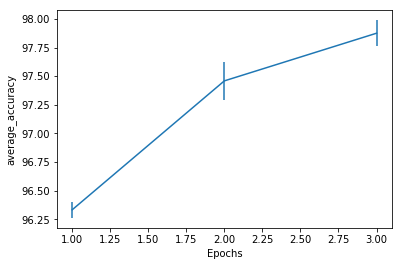

In [7]:
# Create data for plotting
epochs = performance.shape[1]
x = np.arange(1,1+epochs)
y = np.mean(performance,0)
yerr = np.std(performance,0)

# Plot!
plt.figure()
plt.errorbar(x, y, yerr=yerr)
plt.xlabel('Epochs')
plt.ylabel(measure)
plt.show()

# Mnist experiments

In [8]:
def get_minst_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),
    'sgdtype': {sgdtype}
    }
    
    if sgdtype == 'exact ISGD':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [10],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    return condition

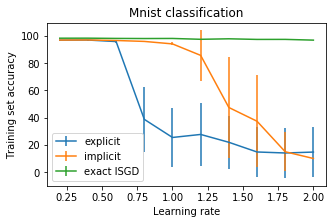

In [82]:
# Select what parameters to fix
measure = 'average_accuracy' # 'average_loss' # 
dataset = 'train'
scatter = False

# Values to iterate over
learning_rates = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6,1.8, 2.0]
sgdtypes = ['explicit', 'implicit', 'exact ISGD']

# Initialize results dictionary
results = {sgdtype: {} for sgdtype in sgdtypes}

# Gather the data
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_conditions(sgdtype, lr)
        anticondition = dict() if sgdtype == 'exact ISGD' else {'inner_ISGD_iterations': [0,100]}
        experiments = load_experiments_satisfying_conditions(conditions, anticondition)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        if scatter:
            results[sgdtype][lr] = performance
        else:
            results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Prepare filename for saving the plot
file_name = ('../plots/mnist_classification_' 
             + measure 
             + ('_scatter' if scatter else '') 
             + ('_test' if dataset == 'test' else '') 
             + '.pdf')

# Plot results
with PdfPages(file_name) as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    
    # Iterate over combinations and plot
    for sgdtype in ({'explicit', 'implicit'} if scatter else sgdtypes):
        if scatter:
            for lr in learning_rates:
                y = results[sgdtype][lr]
                x = lr * np.ones(results[sgdtype][lr].shape)
                color = None
                if sgdtype=='explicit':
                    color='C0'
                elif sgdtype=='implicit':
                    color='C1'
                elif sgdtype=='exact ISGD':
                    color='C2'
                plt.scatter(x, y,color=color, alpha=0.25)
        else:
            x = learning_rates
            y = [results[sgdtype][lr][0] for lr in learning_rates]
            yerr = [results[sgdtype][lr][1] for lr in learning_rates]
            plt.errorbar(x, y, yerr=yerr, label=sgdtype)
            
    # Set labels and title
    plt.xlabel('Learning rate')
    ylabel = ( ('Training ' if dataset == 'train' else 'Test ')
              + ('set loss' if measure == 'average_loss' else 'set accuracy'))
    plt.ylabel(ylabel)
    plt.legend()
    plt.title('Mnist classification')

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Difference between exact formulations

In [10]:
def get_exact_conditions(sgdtype, lr):
    
    if sgdtype == 'exact ISGD 100':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [100],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    if sgdtype == 'exact ISGD 10':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [10],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    return condition

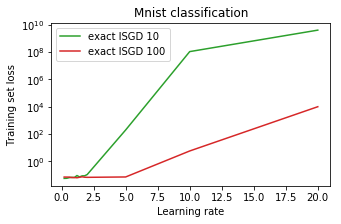

In [84]:
# Select what parameters to fix
measure = 'average_loss' # 'average_accuracy' # 
dataset = 'train'

# Values to iterate over
learning_rates = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6,1.8, 2.0,5.0, 10.0, 20.0]# 
sgdtypes = ['exact ISGD 10', 'exact ISGD 100']

# Initialize results dictionary
results = {sgdtype: {} for sgdtype in sgdtypes}

# Gather the data
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_exact_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions, anticondition)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

            
# Prepare filename for saving the plot
file_name = '../plots/exact_ISGD_classification_' + measure + '.pdf'

# Plot results
with PdfPages(file_name) as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    
    # Iterate over combinations and plot
    for sgdtype in sgdtypes:
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.semilogy(x, y, label=sgdtype, color='C2' if sgdtype=='exact ISGD 10' else 'C3')
            
    # Set labels and title
    plt.xlabel('Learning rate')
    plt.ylabel('Training set loss' if measure == 'average_loss' else 'Training set accuracy')
    plt.legend()
    plt.title('Mnist classification')

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Mnist experiments with intra-epoch losses

In [12]:
def get_minst_intra_epoch_conditions(lr):
    condition = {
    'architecture': ['convffnn'],
    'batch_size': [100],
    'clipping_threshold': [0.0],
    'dataset_name': ['mnist'],
    'epochs': [1],
    'initialization_scale': ['\sqrt{\frac{6}{n+m}}'],
    'intra_epoch': [True],
    'lr': [lr],#, 
    'momentum': [0.0],
    'mu': [0.0],
    'nodes': [50],
    'seed': list(range(1,6)),
    'sgdtype': ['explicit']
    }
    
    return condition

In [13]:
def get_per_intra_epoch_performance(experiments, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_loss_intra_epoch', 'average_accuracy_intra_epoch'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_intra = len(experiments[0]['results'][measure])
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_intra))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][measure]
        
    return performance
        

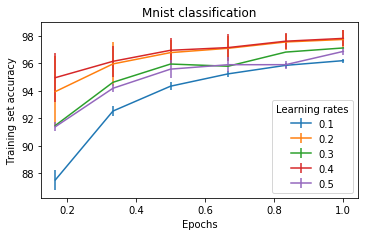

In [93]:
# Select what parameters to fix
measure = 'average_accuracy_intra_epoch' #'average_loss_intra_epoch' # 
dataset = 'train'
scatter = False

# Values to iterate over
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]#, 1.0]
sgdtypes = 'explicit'

# Initialize results dictionary
results = {}

# Gather the data
for lr in learning_rates:
    conditions = get_minst_intra_epoch_conditions(lr)
    experiments = load_experiments_satisfying_conditions(conditions)
    results[lr] = get_per_intra_epoch_performance(experiments, measure)
    
# Prepare filename for saving the plot
file_name = '../plots/intra_epoch_' + measure + '.pdf'

# Plot results
with PdfPages(file_name) as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    
    # Iterate over combinations and plot
    num_intra = len(experiments[0]['results'][measure])
    x = list(np.arange(1, 1 + num_intra) / num_intra)
    for lr in learning_rates:
        y = np.mean(results[lr],axis=0)
        yerr = np.std(results[lr],axis=0)
        plt.errorbar(x, y, yerr=yerr, label=lr)
            
    # Set labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Training set loss' if measure == 'average_loss_intra_epoch' else 'Training set accuracy')
    plt.legend(title='Learning rates')
    plt.tight_layout(pad=0.3)
    plt.title('Mnist classification')

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Mnist experiments with clipping

In [15]:
def get_minst_clipping_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {1.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),# - set([1]),
    'sgdtype': {sgdtype}
    }
    
    return condition

In [16]:
def get_minst_clipping_anti_conditions(sgdtype, lr):
    condition = {
    'inner_ISGD_iterations': {0, 10},  # '0.1'
    'intra_epoch': {True, False}
    }
    
    return condition

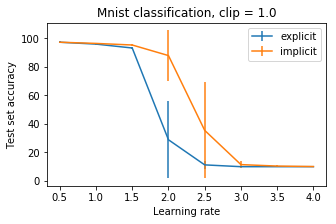

In [101]:
# Select what parameters to fix
measure = 'average_accuracy' # 'average_loss' # 
dataset = 'test'
scatter = False

# Values to iterate over
learning_rates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4]
sgdtypes = ['explicit', 'implicit']

# Initialize results dictionary
results = {sgdtype: {} for sgdtype in sgdtypes}

# Gather the data
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_clipping_conditions(sgdtype, lr)
        anti_conditions = get_minst_clipping_anti_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions, anti_conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        if scatter:
            results[sgdtype][lr] = performance
        else:
            results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Prepare filename for saving the plot
file_name = ('../plots/mnist_classification_clipping_' 
             + measure 
             + ('_scatter' if scatter else '') 
             + ('_test' if dataset == 'test' else '') 
             + '.pdf')

# Plot results
with PdfPages(file_name) as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    
    # Iterate over combinations and plot
    for sgdtype in sgdtypes:
        if scatter:
            for lr in learning_rates:
                y = results[sgdtype][lr]
                x = lr * np.ones(results[sgdtype][lr].shape)
                color = None
                if sgdtype=='explicit':
                    color='C0'
                elif sgdtype=='implicit':
                    color='C1'
                plt.scatter(x, y,color=color, alpha=0.25)
        else:
            x = learning_rates
            y = [results[sgdtype][lr][0] for lr in learning_rates]
            yerr = [results[sgdtype][lr][1] for lr in learning_rates]
            plt.errorbar(x, y, yerr=yerr, label=sgdtype)
            
    # Set labels and title
    plt.xlabel('Learning rate')
    ylabel = ( ('Training ' if dataset == 'train' else 'Test ')
              + ('set loss' if measure == 'average_loss' else 'set accuracy'))
    plt.ylabel(ylabel)
    plt.title('Mnist classification, clip = 1.0')
    plt.legend()

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Autoencoder experiments

In [134]:
def get_minst_autoencoder_conditions(sgdtype, lr, clip):
    condition = {
    "architecture": {"autoencoder"},
    "batch_size": {100},
    "clipping_threshold": {clip},
    "dataset_name": {"mnist_autoencoder"},
    "epochs": {1},
    "initialization_scale": {"\\sqrt{\frac{6}{n+m}}"},
    "lr": {lr},
    "momentum": {0.0},
    "mu": {0.0},
    "seed": set(range(1,21)),
    "sgdtype": {sgdtype},
    "data_type": {"autoencoder"}
    }
    
    return condition

No handles with labels found to put in legend.


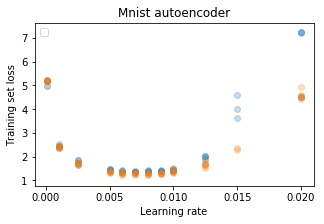

No handles with labels found to put in legend.


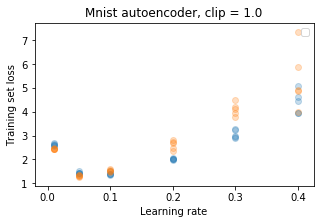

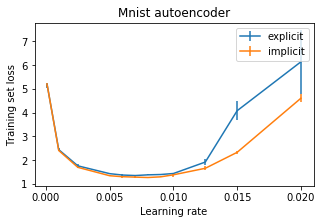

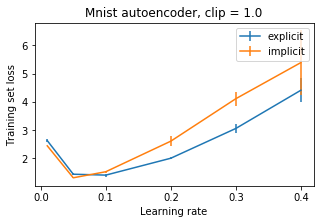

No handles with labels found to put in legend.


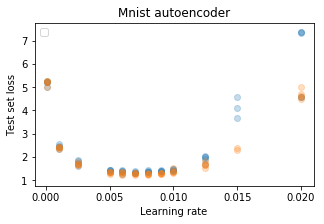

No handles with labels found to put in legend.


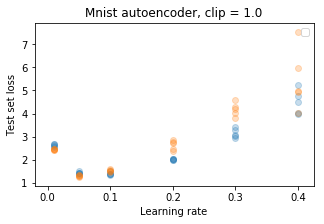

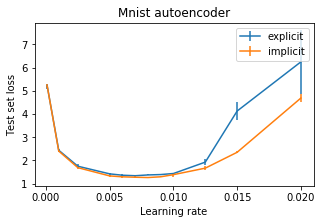

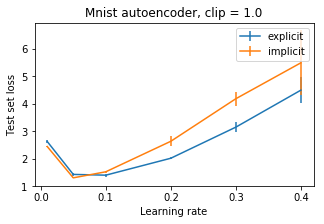

In [212]:
# Select what parameters to fix
measure = 'average_loss'
for dataset in ['train', 'test']:
    for scatter in [True, False]:
        for clip in [0.0, 1.0]:

            # Values to iterate over
            if clip == 0.0:
                learning_rates = [0.0001,0.001, 0.0025, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.0125, 0.015, 0.02]
            else:
                learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4] # , 0.5
            sgdtypes = ['explicit', 'implicit']

            # Initialize results dictionary
            results = {sgdtype: {} for sgdtype in sgdtypes}

            # Gather the data
            for sgdtype in sgdtypes:
                for lr in learning_rates:
                    conditions = get_minst_autoencoder_conditions(sgdtype, lr, clip)
                    experiments = load_experiments_satisfying_conditions(conditions)
                    performance = get_per_epoch_performance(experiments, dataset, measure)
                    if scatter:
                        results[sgdtype][lr] = performance
                    else:
                        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

            # Prepare filename for saving the plot
            clip_str = str(clip).replace('.','_')
            file_name = ('../plots/mnist_autoencoder_' 
                         + measure 
                         + ('_scatter' if scatter else '') 
                         + '_clip_' + clip_str
                         + ('_test' if dataset == 'test' else '') 
                         + '.pdf')

            # Plot results
            with PdfPages(file_name) as pdf:
                plt.figure(figsize=(5,3))#Default = (8.0, 6.0)

                # Iterate over combinations and plot
                for sgdtype in ({'explicit', 'implicit'} if scatter else sgdtypes):
                    if scatter:
                        for lr in learning_rates:
                            y = results[sgdtype][lr]
                            x = lr * np.ones(results[sgdtype][lr].shape)
                            color = None
                            if sgdtype=='explicit':
                                color='C0'
                            elif sgdtype=='implicit':
                                color='C1'
                            elif sgdtype=='exact ISGD':
                                color='C2'
                            plt.scatter(x, y,color=color, alpha=0.25)
                    else:
                        x = learning_rates
                        y = [results[sgdtype][lr][0] for lr in learning_rates]
                        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
                        plt.errorbar(x, y, yerr=yerr, label=sgdtype)

                # Set labels and title
                plt.xlabel('Learning rate')
                ylabel = ( ('Training ' if dataset == 'train' else 'Test ')
                          + ('set loss' if measure == 'average_loss' else 'set accuracy'))
                plt.ylabel(ylabel)
                plt.legend()
                title = 'Mnist autoencoder' + ((', clip = ' + str(clip)) if clip != 0.0 else '')
                plt.title(title)

                # Specify the maximum number of ticks and x-axis limits
                ax = plt.gca() 
                if scatter and clip == 0.0:
                    ax.set_xlim(-0.000895, 0.020995) # This is the same as when scatter = False
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))

                # Save figure
                pdf.savefig(bbox_inches="tight")
                plt.show()

# RNN music

In [39]:
def get_music_conditions(sgdtype, lr, dataset_name, clip):
    
    condition = {
        'architecture': ['music'],
        'batch_size': [100],
        'clipping_threshold': [clip],
        'dataset_name': [dataset_name],
        'epochs': [5],
        'initialization_scale': ['\sqrt{\frac{6}{n+m}}'],  # '0.1'
        'inner_ISGD_iterations': [0],
        'intra_epoch': [False],
        'lr': [lr],
        'momentum': [0.0],
        'mu': [0.0],
        'nodes': [300],
        'seed': list(range(1,6)),
        'sgdtype': [sgdtype]}
    
    return condition
 

No handles with labels found to put in legend.


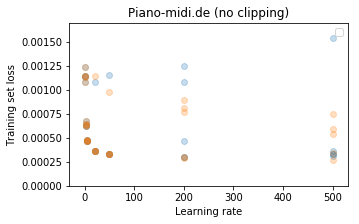

No handles with labels found to put in legend.


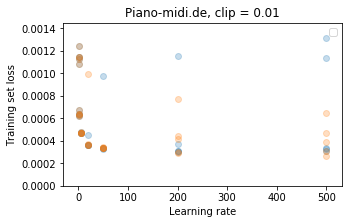

No handles with labels found to put in legend.


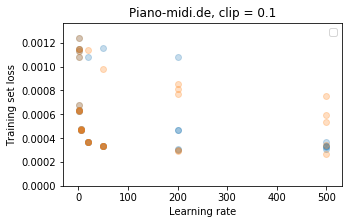

No handles with labels found to put in legend.


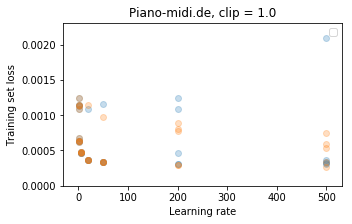

No handles with labels found to put in legend.


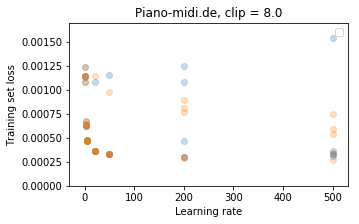

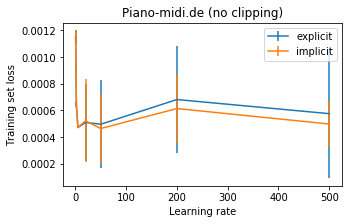

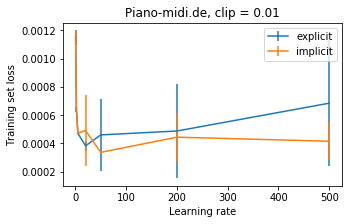

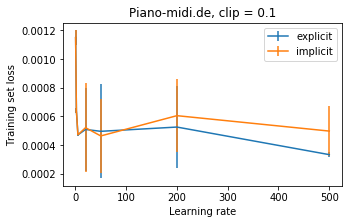

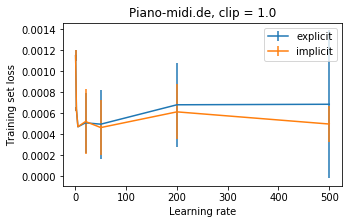

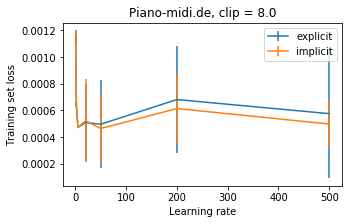

No handles with labels found to put in legend.


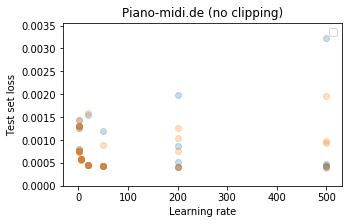

No handles with labels found to put in legend.


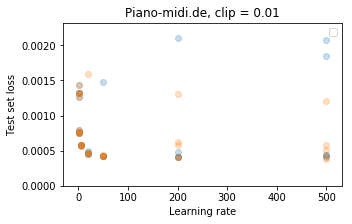

No handles with labels found to put in legend.


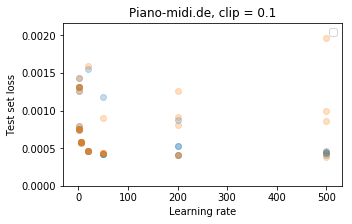

No handles with labels found to put in legend.


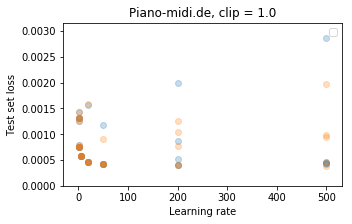

No handles with labels found to put in legend.


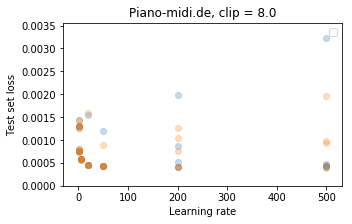

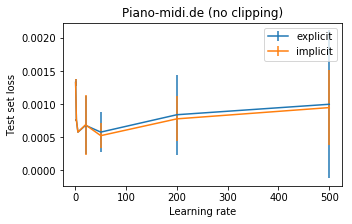

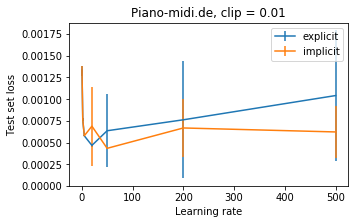

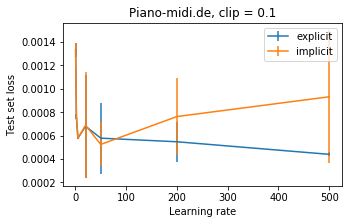

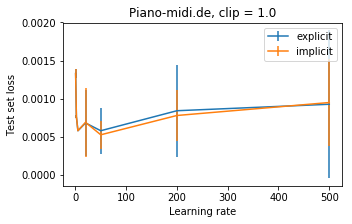

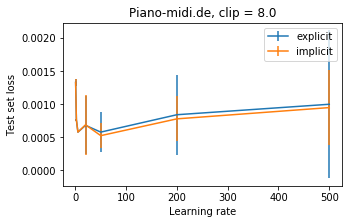

In [201]:
# Select what parameters to fix
measure = 'average_loss'
dataset_name = 'Piano-midi.de'#'MuseData'# 'Nottingham' #'JSB Chorales'#

for dataset in ['train', 'test']:
    for scatter in [True, False]:
        for clip in [0.0, 0.01, 0.1, 1.0, 8.0]:

            # Values to iterate over
            learning_rates = [0.5, 2.0, 5.0, 20.0, 50.0, 200.0, 500.0]#] #
            sgdtypes = ['explicit', 'implicit']

            # Initialize results dictionary
            results = {sgdtype: {} for sgdtype in sgdtypes}

            # Gather the data
            results = {sgdtype: {} for sgdtype in sgdtypes}
            for sgdtype in sgdtypes:
                for lr in learning_rates:
                    conditions = get_music_conditions(sgdtype, lr, dataset_name, clip)
                    experiments = load_experiments_satisfying_conditions(conditions)
                    performance = get_per_epoch_performance(experiments, dataset, measure)[:,epoch_num]
                    if scatter:
                        results[sgdtype][lr] = performance
                    else:
                        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

            # Prepare filename for saving the plot
            clip_str = str(clip).replace('.','_')
            file_name = ('../plots/' 
                         + '_'.join(dataset_name.split('.')[0].split()) 
                         +'_' + measure 
                         + ('_scatter' if scatter else '') 
                         + ('_test' if dataset == 'test' else '') 
                         + '_clip_' + clip_str 
                         + '.pdf')

            # Plot results
            with PdfPages(file_name) as pdf:
                plt.figure(figsize=(5,3))#Default = (8.0, 6.0)

                # Iterate over combinations and plot
                max_y = 0 # Used for setting the y axis limits
                for sgdtype in sgdtypes:
                    if scatter:
                        for lr in learning_rates:
                            y = results[sgdtype][lr]
                            max_y = max(max_y, max(y))
                            x = lr * np.ones(results[sgdtype][lr].shape)
                            color = None
                            if sgdtype=='explicit':
                                color='C0'
                            elif sgdtype=='implicit':
                                color='C1'
                            plt.scatter(x, y,color=color, alpha=0.25)
                    else:
                        x = learning_rates
                        y = [results[sgdtype][lr][0] for lr in learning_rates]
                        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
                        plt.errorbar(x, y, yerr=yerr, label=sgdtype)

                # Set labels and title
                plt.xlabel('Learning rate')
                ylabel = ( ('Training ' if dataset == 'train' else 'Test ')
                          + ('set loss' if measure == 'average_loss' else 'set accuracy'))
                plt.ylabel(ylabel)
                plt.legend()
                title = dataset_name + ((', clip = ' + str(clip)) if clip != 0.0 else ' (no clipping)')
                plt.title(title)

                # Specify the maximum number of ticks and x-axis limits
                if scatter:
                    ax = plt.gca()
                    ax.set_ylim(0.0, 1.1*max_y)

                # Save figure
                pdf.savefig(bbox_inches="tight")
                plt.show()
    

# Classification

In [202]:
def get_num_datapoints_classes(dataset_name):
    dataset_path = '../data/classification/' + dataset_name + '/'

    x = np.loadtxt(open(dataset_path + dataset_name + '_py.dat'), delimiter=",")
    y = np.loadtxt(open(dataset_path + 'labels_py.dat'), delimiter=",")

    num_datapoints = y.shape[0]
    num_classes = np.max(y) + 1 
    
    return num_datapoints, num_classes

In [203]:
def get_classification_conditions(sgdtype, lr, dataset_name):
    
    condition = {
    "architecture": ['classification'],
    "batch_size": [100],
    "clipping_threshold": [0.0],
    "dataset_name": [dataset_name],
    "epochs": [10],
    "initialization_scale": ["\\sqrt{\frac{6}{n+m}}"],
    "inner_ISGD_iterations": [0],
    "intra_epoch": [False],
    "lr": [lr],
    "momentum": [0.0],
    "mu": [0.0],
    "nodes": [50],
    "seed": [1,2,3,4,5],
    "sgdtype": [sgdtype]
}
    
    return condition
 

In [217]:
# Group datasets into being large (more than 1000 datapoints) 
# and small (less than 1000 datapoints)
small_datasets = set()
large_datasets = set()

# dataset_names = ['annealing', 'abalone', 'adult', 'connect-4']
dataset_names = sorted([d for d in os.listdir('../data/classification') if d.count('.') == 0])
for dataset_name in dataset_names:
    num_datapoints, num_classes = get_num_datapoints_classes(dataset_name)
    if num_datapoints >= 1000:
        large_datasets.add(dataset_name)
    else:
        small_datasets.add(dataset_name)

In [229]:
sorted(list(large_datasets))[22]

'optical'

In [213]:
# Select what parameters to fix
measure = 'average_loss'
dataset = 'train'
epoch_num = 9

# Values to iterate over
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 30.0, 50.0]
sgdtypes = ['explicit', 'implicit']

# Initialize results dictionary
results = dict()

# Gather the data
for dataset_name in dataset_names:
    print(dataset_name)
    sgdtypes = ['explicit', 'implicit']
    results[dataset_name] = {sgdtype: {} for sgdtype in sgdtypes}
    for sgdtype in sgdtypes:
        for lr in learning_rates:
            conditions = get_classification_conditions(sgdtype, lr, dataset_name + '_classification')
            experiments = load_experiments_satisfying_conditions(conditions)
            results[dataset_name][sgdtype][lr] = -np.ones(10)
            performance = get_per_epoch_performance(experiments, dataset, measure)[0]
            results[dataset_name][sgdtype][lr] = performance


abalone
acute-inflammation
acute-nephritis
adult
annealing
arrhythmia
audiology-std
balance-scale
balloons
bank
blood
breast-cancer
breast-cancer-wisc
breast-cancer-wisc-diag
breast-cancer-wisc-prog
breast-tissue
car
cardiotocography-10clases
cardiotocography-3clases
chess-krvk
chess-krvkp
congressional-voting
conn-bench-sonar-mines-rocks
conn-bench-vowel-deterding
connect-4
contrac
credit-approval
cylinder-bands
dermatology
echocardiogram
ecoli
energy-y1
energy-y2
fertility
flags
glass
haberman-survival
hayes-roth
heart-cleveland
heart-hungarian
heart-switzerland
heart-va
hepatitis
hill-valley
horse-colic
ilpd-indian-liver
image-segmentation
ionosphere
iris
led-display
lenses
letter
libras
low-res-spect
lung-cancer
lymphography
magic
mammographic
miniboone
molec-biol-promoter
molec-biol-splice
monks-1
monks-2
monks-3
mushroom
musk-1
musk-2
nursery
oocytes-merluccius-nucleus-4d
oocytes-merluccius-states-2f
oocytes-trisopterus-nucleus-2f
oocytes-trisopterus-states-5b
optical
ozone
page-

In [246]:
# Generate aggregate statistics
threshold = 0.25 # Fraction by which one method outperforms the other
epoch_num = 9
size_datasets = small_datasets #large_datasets # 

# Initialize ternary performance matrix
# with a row for each dataset and column for each learning rate.
# The element will be:
#     +1 if ISGD > 1.1 ESGD
#     -1 if ESGD > 1.1 ISGD
#     0  otherwise
performance_ternary = np.zeros((len(results), len(learning_rates)))
dataset_index = 0
for key, value in results.items():
    if key in size_datasets:
        explicit_values = np.array([value['explicit'][lr][epoch_num] for lr in learning_rates])
        implicit_values = np.array([value['implicit'][lr][epoch_num] for lr in learning_rates])
        performance_list = (1.0 * (implicit_values < (1+threshold) * explicit_values)
                           - 1.0 * (explicit_values < (1+threshold) * implicit_values))
        performance_ternary[dataset_index, :] = performance_list
        dataset_index += 1
    
# Calculate aggregats
# print('Ternary performance matrix: ', performance_ternary)
imp_better = np.sum(1.0 *(performance_ternary == 1.0), axis=0)
exp_better = np.sum(1.0 *(performance_ternary == -1.0), axis=0)
print('Implicit better: ', imp_better)
print('Explicit better: ',  exp_better)
print('Difference implicit better: ',  imp_better - exp_better)
print('Number datasets: ', dataset_index)

latex_string = 'ISGD better & ' + ' & '.join( str(int(x)) for x in imp_better.tolist()) + '\\tabularnewline\n\\hline\n'
latex_string = latex_string + 'ESGD better & ' + ' & '.join( str(int(x)) for x in exp_better.tolist()) + '\\tabularnewline\n\\hline\\hline\n'
latex_string = latex_string + 'ISGD - ESGD & ' + ' & '.join( str(int(x)) for x in (imp_better - exp_better).tolist()) + '\\tabularnewline'
print(latex_string)

Implicit better:  [ 0.  0.  0.  1.  1.  7. 23. 19. 25. 26.]
Explicit better:  [ 0.  0.  0.  0.  2. 21. 31. 41. 33. 35.]
Difference implicit better:  [  0.   0.   0.   1.  -1. -14.  -8. -22.  -8.  -9.]
Number datasets:  75
ISGD better & 0 & 0 & 0 & 1 & 1 & 7 & 23 & 19 & 25 & 26\tabularnewline
\hline
ESGD better & 0 & 0 & 0 & 0 & 2 & 21 & 31 & 41 & 33 & 35\tabularnewline
\hline\hline
ISGD - ESGD & 0 & 0 & 0 & 1 & -1 & -14 & -8 & -22 & -8 & -9\tabularnewline


'0.0 & 0.0 & 0.0 & 1.0 & 1.0 & 7.0 & 23.0 & 19.0 & 25.0 & 26.0'

In [230]:
# Decide on what size datasets
size_datasets = large_datasets # small_datasets #

# Generate latex table
latex_strings = []

for dataset_name in dataset_names:
    if dataset_name in size_datasets:
        latex_row_list = dict()
        for sgdtype in sgdtypes:
            latex_row_list[sgdtype] = (['\\multirow{2}{*}{'+ dataset_name +'}'
                                        if sgdtype == 'explicit' 
                                        else ''] 
                                       + ['{0:.2f}'.format(float(results[dataset_name][sgdtype][lr][epoch_num])) 
                                          for lr in learning_rates] 
                                       + [sgdtype])

        latex_strings.append(' & '.join(latex_row_list['explicit']) 
              + '\\tabularnewline\n' 
              + ' & '.join(latex_row_list['implicit'])
              )

print(''.join(latex_strings))

\multirow{2}{*}{abalone} & 1.11 & 1.10 & 0.83 & 0.77 & 0.76 & 12.30 & 6.13 & 25.20 & 57.09 & 212.61 & explicit\tabularnewline
 & 1.11 & 1.10 & 0.83 & 0.77 & 0.77 & 2.65 & 3.18 & 22.95 & 98.31 & 84.63 & implicit\tabularnewline
\hline
\multirow{2}{*}{adult} & 0.55 & 0.35 & 0.32 & 0.32 & 0.31 & 0.36 & 1.52 & 2.97 & 17.99 & 27.19 & explicit\tabularnewline
 & 0.55 & 0.35 & 0.32 & 0.32 & 0.32 & 0.34 & 1.15 & 4.31 & 12.22 & 20.27 & implicit\tabularnewline
\hline
\multirow{2}{*}{bank} & 0.60 & 0.36 & 0.25 & 0.27 & 0.30 & 0.52 & 1.29 & 14.74 & 27.23 & 113.73 & explicit\tabularnewline
 & 0.60 & 0.36 & 0.25 & 0.27 & 0.29 & 0.35 & 1.46 & 21.44 & 65.24 & 19.08 & implicit\tabularnewline
\hline
\multirow{2}{*}{car} & 1.18 & 1.01 & 0.85 & 0.50 & 0.39 & 0.59 & 5.28 & 4.55 & 53.97 & 106.93 & explicit\tabularnewline
 & 1.18 & 1.01 & 0.85 & 0.50 & 0.47 & 2.40 & 2.12 & 10.38 & 213.52 & 122.84 & implicit\tabularnewline
\hline
\multirow{2}{*}{cardiotocography-10clases} & 2.30 & 2.18 & 1.24 & 0.68 & 0.68 & 4.